In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata
from scipy.stats import pearsonr

In [2]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

# Noise ceilings and floors

## Univariate noise ceiling

The noise ceiling is how much between-participant variance could possibly be modeled given the amplitude of measurement noise. This is used as a point of comparison: how good does our model do, relative to the ceiling?

Another way to think of it: the noise ceiling is the performance of the best possible model of the data, which we estimate using the data itself, assuming that all of the variance across participants is noise.

A measurement of a participant is a 1-dimensional vector of length N. We assume no meaningful individual differences between participants, so each participant is just the same "seed vector" plus participant-specific noise.

Our seed vector will be one period of a sine wave, for legibility.

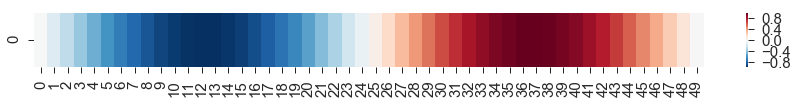

In [3]:
seed_vector = np.sin(np.linspace(-np.pi, np.pi, 50))
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(seed_vector[:, np.newaxis].T)

In [4]:
def gen_participants(n_participants, seed_vector, noise_coef):
    participants = np.tile(seed_vector, (n_participants, 1))
    noise = (np.random.random((n_participants, seed_vector.shape[0])) - .5) * 2 * noise_coef
    return participants + noise

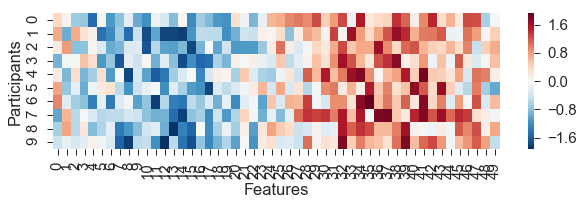

In [5]:
n_participants = 10
noise_coef = 1
participants = gen_participants(n_participants, seed_vector, noise_coef)
fig, ax = plt.subplots(figsize=(10, n_participants / 4))
sns.heatmap(participants)
plt.xlabel('Features')
plt.ylabel('Participants')

We're interested in how well correlated the result predicted by some model is with the actual data. In this case the seed vector is the true model, so we can use that. In ideal measurement conditions, the average correlation of the model with our data would be 1...

In [6]:
def test_group(model, participants, correlation="spearman"):
    if correlation == 'pearson':
        # z-score data
        participants = ((participants - participants.mean(axis=1, keepdims=True)) / 
                         participants.std(axis=1, keepdims=True))
    
    if correlation == 'spearman':
        # rank transform data
        model = rankdata(model)
        participants = np.apply_along_axis(rankdata, 1, participants)
    
    correlations = []
    for p in participants:
        correlations.append(pearsonr(model, p))
        
    group_mean = np.mean([c[0] for c in correlations])
    return group_mean, correlations

In [7]:
group_mean, correlations = test_group(seed_vector, participants, "spearman")
group_mean.round(2)

0.77

...but because of inter-participant measurement noise, we get a lower value. Let's calculate the noise ceiling to see how this result compares.

First we figure out what the best fitting model for the data could be. In the case of this correlation analysis, the best fitting model is simply the mean of the data.

The upper bound of the noise ceiling (the best possible result the true model could achieve given these data and this analysis) is the mean of the correlations of this best fitting model with each of the data points.

The lower bound of the noise ceiling (the worst possible result the true model could achieve given these data and this analysis) is estimated using a leave-one-out procedure: for each left out participant, calculate their correlation with a best fitting model based on only the left-in participants.

In [8]:
def noise_ceiling(data, correlation="spearman"):
    if correlation == 'pearson':
        # z-score reference DSMs
        data = ((data - data.mean(axis=1, keepdims=True)) / 
                 data.std(axis=1, keepdims=True))
    
    if correlation == 'spearman':
        # rank transform reference DSMs
        data = np.apply_along_axis(rankdata, 1, data)
    
    # Calculate best fit to transformed reference DSMs
    best_fit = data.mean(axis=0)
    if correlation == 'spearman':
        best_fit = rankdata(best_fit)

    # Lower bound
    # Estimated using a leave-one-out procedure
    dsm_corrs = list()
    for i in range(data.shape[0]):
        dsm_i = data[i]
        data_loo_ix = np.repeat([True], data.shape[0])
        data_loo_ix[i] = False
        data_loo = data[data_loo_ix]
        loo_mean = data_loo.mean(axis=0)
        if correlation == 'spearman':
            loo_mean = rankdata(loo_mean)
        r = pearsonr(dsm_i, loo_mean)
        dsm_corrs.append(r[0])
        
    lower_bound = np.mean(dsm_corrs)
    
    # Upper bound
    # The closed-form solution for the upper bound is the mean
    # correlation across subjects to the best fit DSM
    corr_best_fit = lambda dsm: pearsonr(dsm, best_fit)[0]
    upper_bound = np.apply_along_axis(corr_best_fit, 1, data).mean()
    
    return (lower_bound, upper_bound)

In [9]:
np.round(noise_ceiling(participants), 2)

array([0.74, 0.8 ])

Our result is right between the bounds of the noise ceiling, so we can be confident that our model is good.

Let's look at how this changes with the signal-to-noise ratio:

In [10]:
noise_coefs = np.linspace(0, 2, 21)

In [11]:
group_means = []
noise_ceilings = []
for noise_coef in noise_coefs:
    participants = gen_participants(n_participants, seed_vector, noise_coef)
    group_mean, correlations = test_group(seed_vector, participants, "spearman")
    group_means.append(group_mean)
    noise_ceilings.append(noise_ceiling(participants))

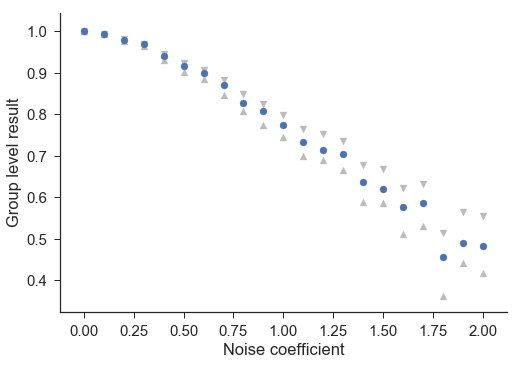

In [12]:
for noise_coef, nc in zip(noise_coefs, noise_ceilings):
    plt.scatter(noise_coef, nc[0], marker='^', c='#bbbbbb')
    plt.scatter(noise_coef, nc[1], marker='v', c='#bbbbbb')
plt.scatter(noise_coefs, group_means)
plt.xlabel("Noise coefficient")
plt.ylabel("Group level result")
sns.despine()

As measurement noise increases, the group mean correlation with the true model drops while staying within a gradually widening noise ceiling.

## Multivariate noise ceiling

An interesting issue with this univariate formulation of the noise ceiling is that it doesn't make sense for multivariate regression, especially if there are meaningful inter-participant differences that are not due to measurement noise.

Let's assume we have two seed vectors $a$ and $b$, and that each participant expresses each seed vector to different degrees, and (for illustrative purposes) that there is zero measurement noise:

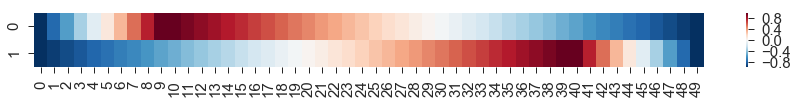

In [13]:
seed_vector_a = np.hstack([np.linspace(-1, 1, 10), np.linspace(1, -1, 40)])
seed_vector_b = np.hstack([np.linspace(-1, 1, 40), np.linspace(1, -1, 10)])
seed_vectors = np.array([seed_vector_a, seed_vector_b])
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(seed_vectors);

In [14]:
def gen_participants_multi(n_participants, seed_vectors, noise_coef):
    participants = []
    participant_coefs = []
    for i in range(n_participants):
        p_seed_vector_coefs = np.random.random(len(seed_vectors))
        participant_coefs.append(p_seed_vector_coefs)
        participants.append(np.sum(p_seed_vector_coefs[:, np.newaxis] * seed_vectors, axis=0))
    noise = (np.random.random((n_participants, seed_vectors[0].shape[0])) - .5) * 2 * noise_coef
    return participants + noise, participant_coefs

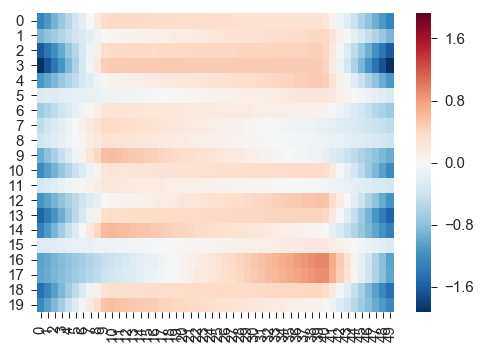

In [15]:
participants, participant_coefs = gen_participants_multi(20, seed_vectors, 0)
sns.heatmap(participants)

In [16]:
def multivariate_simulation(participants, predictors):
    from sklearn.linear_model import LinearRegression
    model_scores = []
    model_coefs = []
    for participant in participants:
        model = LinearRegression(fit_intercept=False)
        model.fit(predictors.T, participant)
        model_coefs.append(model.coef_)
        model_scores.append(model.score(predictors.T, participant))
    return model_scores, model_coefs

In [18]:
model_scores, model_coefs = multivariate_simulation(participants, seed_vectors)

Linear regression perfectly recovers the relative weights of each seed vector for each participant:

In [19]:
np.allclose(model_coefs, participant_coefs)

True

And, because there was no noise, each participant was perfectly modeled, so the mean $R^2$ across participants is 1.0, which exceeds the upper bound of the univariate noise ceiling.

In [20]:
np.mean(model_scores)

1.0

In [21]:
noise_ceiling(participants, correlation="pearson")

(0.891281467528821, 0.9017925993693741)

Let's visualize this with different amounts of noise:

In [24]:
group_scores = []
noise_ceilings = []
for noise_coef in noise_coefs:
    participants, participant_coefs = gen_participants_multi(20, seed_vectors, noise_coef)
    model_scores, model_coefs = multivariate_simulation(participants, seed_vectors)
    group_scores.append(np.mean(model_scores))
    noise_ceilings.append(noise_ceiling(participants, correlation="pearson"))

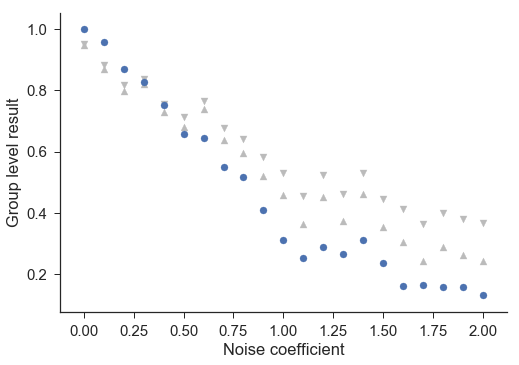

In [25]:
for noise_coef, nc in zip(noise_coefs, noise_ceilings):
    plt.scatter(noise_coef, nc[0], marker='^', c='#bbbbbb')
    plt.scatter(noise_coef, nc[1], marker='v', c='#bbbbbb')
plt.scatter(noise_coefs, group_scores)
plt.xlabel("Noise coefficient")
plt.ylabel("Group level result")
sns.despine()

A bit garbage, isn't it? The performance of the true model exceeds the noise ceiling when noise is low and is below the noise floor when noise is high.

So the univariate noise ceiling is inappropriate for multivariate regression. Could there be a better way?

Rather than creating the best fitting model by taking the mean of the data, let's instead perform independent components analysis (ICA) and use the resulting components as a predictors in a multiple linear regression model to estimate a noise ceiling for $R^2$.

(I'm a little uncomfortable with this next bit. Should I be? Is this wrong?)

Because we know the data will include noise, we train our ICA model using more components than the number of predictors in our regression model.

In [32]:
def multivariate_noise_ceiling(data, n_predictors, ica=False, padding_components=1):
    from sklearn.decomposition import PCA, FastICA
    from sklearn.linear_model import LinearRegression
        
    # Upper bound
    if ica:
        reduce = FastICA(n_components=n_predictors + padding_components)
    else:
        reduce = PCA(n_components=n_predictors + padding_components)
    reduce.fit(data)
    best_predictors = reduce.components_
    
    ub_scores = list()
    for sample in data:
        model = LinearRegression()
        model.fit(best_predictors.T, sample)
        ub_scores.append(model.score(best_predictors.T, sample))
        
    # Lower bound, LOO procedure
    lb_scores = list()
    for i in range(data.shape[0]):
        data_i = data[i]
        data_loo_ix = np.repeat([True], data.shape[0])
        data_loo_ix[i] = False
        data_loo = data[data_loo_ix]
        
        if ica:
            reduce_loo = FastICA(n_components=n_predictors + padding_components)
        else:
            reduce_loo = PCA(n_components=n_predictors + padding_components)
        reduce_loo.fit(data_loo)
        best_predictors_loo = reduce_loo.components_
        model_loo = LinearRegression(fit_intercept=False)
        model_loo.fit(best_predictors_loo.T, data_i)
        lb_scores.append(model_loo.score(best_predictors_loo.T, data_i))
    
    return np.mean(lb_scores), np.mean(ub_scores)

Let's try plotting our results with noise ceilings again, this time using the multivariate approach, and lets up our number of participants to 50 with the hope of making the calculations reasonably stable:

In [47]:
group_scores = []
noise_ceilings = []

noise_coefs = np.linspace(0, 2, 21)

for noise_coef in noise_coefs:
    participants, participant_coefs = gen_participants_multi(50, seed_vectors, noise_coef)
    model_scores, model_coefs = multivariate_simulation(participants, seed_vectors)
    group_scores.append(np.mean(model_scores))
    noise_ceilings.append(multivariate_noise_ceiling(participants, n_predictors=2))

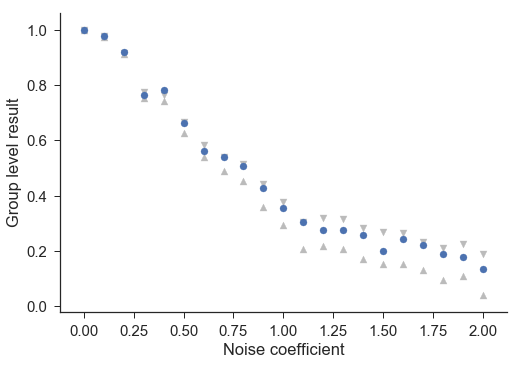

In [48]:
for noise_coef, nc in zip(noise_coefs, noise_ceilings):
    plt.scatter(noise_coef, nc[0], marker='^', c='#bbbbbb')
    plt.scatter(noise_coef, nc[1], marker='v', c='#bbbbbb')
plt.scatter(noise_coefs, group_scores)
plt.xlabel("Noise coefficient")
plt.ylabel("Group level result")
sns.despine()

This is way better, but not perfect:

- The true model outperforms the upper bound of the noise ceiling in some cases, especially if the sample size is low. Why? The PCA/ICA model may be overfitting noise that just happens to be similar across some participants. With larger sample sizes (>100), the true model result nearly always falls between the upper and lower bound.
- Sensitivity to the number of "padding" components. With 0 padding components, the true model result almost always exceeds the upper bound. 1 padding component seems reasonable (to me, who is not a statistician). As the number of noise padding components increases, the regression models using the PCA/ICA predictors overfit the noise, and the performance of the true model drops below the lower bound.
- Fitting the PCA/ICA model can be slow, especially if the sample size/number of participants or noise padding components is large.

## Multivariate noise floor

One concern in a multiple regression analysis is whether you are overfitting measurement noise simply by having a large number of predictors. To make ourselves feel better about our model, we can compare its performance to a noise floor based on random permutations of our model.

In [49]:
def multivariate_noise_floor(data, predictors, n_permutations=1000):
    from sklearn.linear_model import LinearRegression
    scores = np.zeros(n_permutations)
    for pi in range(n_permutations):
        permuted_predictors = list()
        for predictor in predictors:
            permuted_predictors.append(predictor[np.random.permutation(len(predictor))])
        permuted_predictors = np.array(permuted_predictors)
        perm_scores = np.zeros(data.shape[0])
        for ri in range(data.shape[0]):
            model = LinearRegression()
            model.fit(permuted_predictors.T, data[ri])
            perm_scores[ri] = model.score(permuted_predictors.T, data[ri])
        scores[pi] = np.mean(perm_scores)
    return np.mean(scores)

In [50]:
group_scores = []
noise_ceilings = []
noise_floors = []

noise_coefs = np.linspace(0, 2, 21)
noise_coefs[0] = .01  # ICA won't converge unless there's a little noise

for noise_coef in noise_coefs:
    participants, participant_coefs = gen_participants_multi(40, seed_vectors, noise_coef)
    model_scores, model_coefs = multivariate_simulation(participants, seed_vectors)
    group_scores.append(np.mean(model_scores))
    noise_ceilings.append(multivariate_noise_ceiling(participants, n_predictors=2))
    noise_floors.append(multivariate_noise_floor(participants, seed_vectors, n_permutations=500))

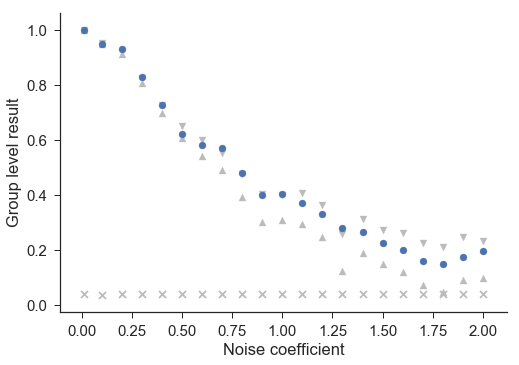

In [51]:
for noise_coef, nc in zip(noise_coefs, noise_ceilings):
    plt.scatter(noise_coef, nc[0], marker='^', c='#bbbbbb')
    plt.scatter(noise_coef, nc[1], marker='v', c='#bbbbbb')
plt.scatter(noise_coefs, noise_floors, marker='x', c='#bbbbbb')
plt.scatter(noise_coefs, group_scores)
plt.xlabel("Noise coefficient")
plt.ylabel("Group level result")
sns.despine()